Ukuran dataset: (10, 6)
   IPK  Jumlah_Absensi  Waktu_Belajar_Jam  Lulus  Rasio_Absensi  IPK_x_Study
0  3.8               3                 10      1       0.214286         38.0
1  2.5               8                  5      0       0.571429         12.5
2  3.4               4                  7      1       0.285714         23.8
3  2.1              12                  2      0       0.857143          4.2
4  3.9               2                 12      1       0.142857         46.8
Train: (8, 5) Test: (2, 5)

=== Logistic Regression (Baseline) ===
F1 Score: 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2


=== Random Forest ===
F1 Score: 1.0
              precision    recall  f1-score   support

           0  

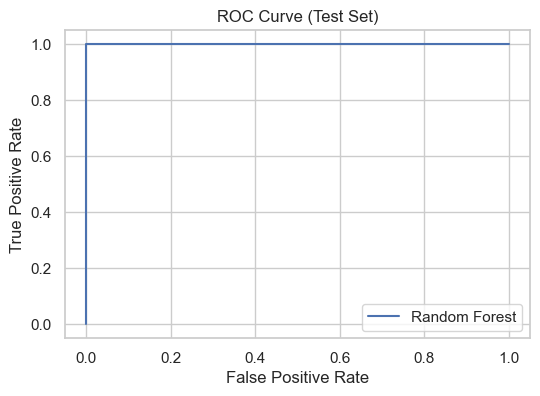

In [1]:
# ======================================================
# 1. Import Library
# ======================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

# Atur style visualisasi
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6,4)

# ======================================================
# 2. Baca Data
# ======================================================
df = pd.read_csv("processed_kelulusan.csv")
print("Ukuran dataset:", df.shape)
print(df.head())

X = df.drop("Lulus", axis=1)
y = df["Lulus"]

# Split Train/Test 80:20 (stratify biar seimbang kelas 0/1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# ======================================================
# 3. Baseline Logistic Regression
# ======================================================
num_cols = X_train.select_dtypes(include="number").columns

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
], remainder="drop")

logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
pipe_lr = Pipeline([("pre", pre), ("clf", logreg)])

pipe_lr.fit(X_train, y_train)
y_test_pred_lr = pipe_lr.predict(X_test)

print("\n=== Logistic Regression (Baseline) ===")
print("F1 Score:", f1_score(y_test, y_test_pred_lr, average="macro"))
print(classification_report(y_test, y_test_pred_lr, digits=3))

# ======================================================
# 4. Model Alternatif: Random Forest
# ======================================================
rf = RandomForestClassifier(
    n_estimators=300, max_features="sqrt", class_weight="balanced", random_state=42
)
pipe_rf = Pipeline([("pre", pre), ("clf", rf)])

pipe_rf.fit(X_train, y_train)
y_test_pred_rf = pipe_rf.predict(X_test)

print("\n=== Random Forest ===")
print("F1 Score:", f1_score(y_test, y_test_pred_rf, average="macro"))
print(classification_report(y_test, y_test_pred_rf, digits=3))

# ======================================================
# 5. Evaluasi Lanjutan: Confusion Matrix & ROC
# ======================================================
print("\nConfusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_test_pred_rf))

if hasattr(pipe_rf.named_steps["clf"], "predict_proba"):
    y_test_proba = pipe_rf.predict_proba(X_test)[:,1]
    print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))

    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.plot(fpr, tpr, label="Random Forest")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test Set)")
    plt.legend()
    plt.show()
